In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


# 1. Bidding in blind auction against competition
Consider bidding in an auction against a competitor, where the highest bidder wins the auction and pays the bid price. The auction is blind, in the sense that bidders are blind to other participants bids.

## 1.1. Competitor bids $\sim F_B$
let $B$ be the comeptitor's bid which follow some stationary distribution $F_B$ parameterized by $\theta$, and let our bid price be denoted by $x$. We win the auction when we bid higher than our competitor. Hence, our stochastic win rate (Hit Ratio) is $W = 1\{x-B\} = H(x-B)$, where $H(\cdot)$ is the Heaviside step function.

\begin{align}
W &= H(x-B) \sim Bern(F_B(x)) \\
\mathbb{E}[W] &= F_B(x) \\
\mathbb{V}[W] &= F_B(x)(1-F_B(x))
\end{align}

If we win the bid, we can sell the asset at a price $x<m$, with a conditional profit of $Pnl=m-x$. Hence, $c$ is our break-even price, or the maximum price we are willing to bid.

\begin{align}
Pnl &= W \cdot(m-x) \\
\mathbb{E}[Pnl] &= F_B(x)(m-x) \\
\mathbb{V}[Pnl] &= F_B(x)(1-F_B(x))(m-x)^2
\end{align}

The only uncertainty in the Pnl comes from the win rate $W$.

Assume that we have participated in $n$ auctions, each auction with bid price and win result given by $\{x_i, w_i\}$, for $i=1,...,n$.

### Maximum Likelihood Estimation

The likelihood is $f_w(\mathbb{w}, \mathbb{x}; \theta) = \prod\limits_{i=1}^n F_B(x_i)^{w_i} (1-F_B(x_i))^{1-w_i}$.

Maximum likelihood estimation yields $\hat{\theta}_n = \underset{\theta}{argmax} f_w(\mathbb{w}, \mathbb{x}; \theta)$.

Now using this estimation, we want to find our next bid such that we maximize expected pnl, or more generally, expectation of some utility function $U(x)$ of pnl.

\begin{align}
    x_{n+1} := \underset{x}{argmax} \; \mathbb{E}[U(Pnl)|\theta=\hat{\theta}_n]
\end{align}

For instance, chosing the exponential utility function $U(x) = (1-e^{-qx})/q$ we get

\begin{align}
    x_{n+1} := \underset{x}{argmax} \; \frac{1-e^{-q(m-x)}}{q}F_B(x; \hat{\theta}_n)
\end{align}

### Bayesian Estimation
Posterior predictive distribution is given by
\begin{align}
    P(w,x|\mathbb{w},\mathbb{x}) = \int f_w(w,x|\theta)P(\theta|\mathbb{w},\mathbb{x}) d\theta
\end{align}
where we can expand 
\begin{align}
    P(\theta|\mathbb{w},\mathbb{x}) = \frac{f_w(\mathbb{w}, \mathbb{x}; \theta) P(\theta)}{P(\mathbb{w},\mathbb{x})} \sim f_w(\mathbb{w}, \mathbb{x}; \theta) P(\theta),
\end{align}
where $P(\theta)$ is our prior.

The next optimal bidprice is given by
\begin{align}
    x_{n+1} := \underset{x}{argmax} \; \frac{1-e^{-q(m-x)}}{q} P(w=1,x|\mathbb{w},\mathbb{x}).
\end{align}

[]

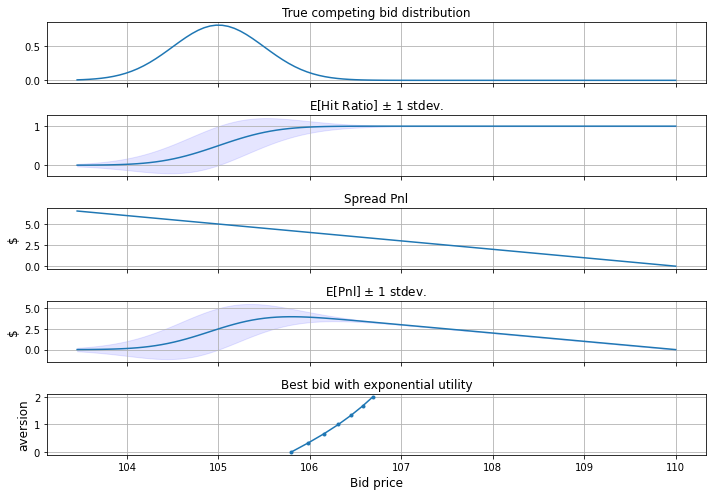

In [2]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
from scipy.optimize import minimize

m = 110 # Break even point.
loc = 105
scale = 0.5
B = stats.norm(loc=loc,scale=scale)
#B = stats.uniform(loc=mu-sigma*3**0.5, scale=2*sigma*3**0.5)
xx = np.linspace(B.ppf(0.001), m, 100)

fig, axs = plt.subplots(5, 1, figsize=(10,7), sharex=True)
axs[0].set_title('True competing bid distribution')
axs[0].plot(xx, B.pdf(xx))

axs[1].set_title('E[Hit Ratio] $\pm$ 1 stdev.')
EW = B.cdf(xx)
VW = B.cdf(xx) * (1 - B.cdf(xx))
axs[1].plot(xx, EW)
axs[1].fill_between(xx, EW - np.sqrt(VW), EW + np.sqrt(VW), color='blue', alpha=0.1)

axs[2].set_title('Spread Pnl')
axs[2].set_ylabel('$', fontsize=12)
axs[2].plot(xx, (m-xx))

axs[3].set_title('E[Pnl] $\pm$ 1 stdev.')
axs[3].set_ylabel('$', fontsize=12)
EPNL = B.cdf(xx)*(m-xx)
axs[3].plot(xx, EPNL)
VPNL = B.cdf(xx) * (m-xx)**2 * (1-B.cdf(xx))
axs[3].fill_between(xx, EPNL - np.sqrt(VPNL), EPNL + np.sqrt(VPNL), color='blue', alpha=0.1)

def eutil(x, q):
    if q == 0.0:
        eutil = (m-x)*B.cdf(x)
    else:
        eutil = 1/q*(1-np.exp(-q*(m-x)))*B.cdf(x)
    return -eutil

qq = np.linspace(0, 2, 6+1)
xoptim = np.zeros_like(qq, float)
x0 = B.stats(moments='m')
for i in range(qq.shape[0]):
    res = minimize(eutil, x0=x0, args=(qq[i]))
    xoptim[i] = res.x
    x0 = res.x

axs[4].set_title('Best bid with exponential utility')
axs[4].set_ylabel('aversion', fontsize=12)
axs[4].set_xlabel('Bid price', fontsize=12)
axs[4].plot(xoptim, qq, marker='.')

for ax in axs:
    ax.grid()
fig.tight_layout()
plt.plot()

## 1.1.1. A simple example
Let the comeptitor's bid follow a staionary Gaussian distribution $B \sim \mathcal{N}(\mu, \sigma^2)$ with unknown mean and known variance. Then $F_B(x) = F\left(\frac{x-\mu}{\sigma}\right)$, where $F$ is the standard normal cdf.

FOr the Bayesian estimation, we assume a gaussian prior.

[]

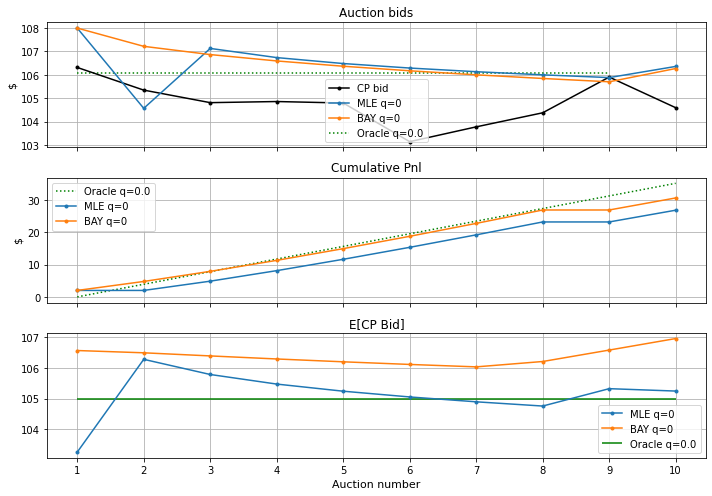

In [3]:
from scipy.optimize import minimize
from scipy import integrate

def logL(x, dist, xprice, xhit):
    cdf = dist(x).cdf(xprice)
    cdf[cdf==1] = 0.9999
    cdf[cdf==0] = 0.0001
    logL = xhit * np.log(cdf) + (1-xhit)*np.log(1-cdf)
    return -logL.sum()

def eutil(x, theta, dist, q):
    if q == 0.0:
        eutil = (m-x)*dist(theta).cdf(x)
    else:
        eutil = 1/q*(1-np.exp(-q*(m-x)))*dist(theta).cdf(x)
    return -eutil

class StratMLE:
    def __init__(self, name, bidinit, breakeven, riskaversion, dist):
        self.name = name
        self.riskaversion = riskaversion
        self.breakeven = breakeven
        self.pnl = []
        self.wins = []
        self.bidprice = []
        self.nextbid = bidinit
        self.theta = []
        self.dist = dist
    
    def step1_auction(self, cpbid): # cheating here, CP's price not public (shouldnt be exposed here)...
        ourbid = self.nextbid
        won = (cpbid < ourbid)
        spread = (self.breakeven - ourbid)
        profit = 1*won*spread
        self.bidprice += [ourbid]
        self.wins += [1*won]
        self.pnl += [profit]
        
    def step2_est_dist(self, sigma):
        args = (self.dist, np.array(self.bidprice), np.array(self.wins))
        theta_guess = self.bidprice[-1]
        res = minimize(logL, x0=theta_guess, args=args)
        self.theta += [res.x[0]]
        
    def step3_est_bid(self):
        args = (self.theta[-1], self.dist, self.riskaversion)
        res_price = minimize(eutil, x0=self.theta[-1], args=args)
        self.nextbid = res_price.x[0]
        
        
class StratBayes:
    def __init__(self, name, prior_dist, breakeven, riskaversion, dist):
        self.name = name
        self.riskaversion = riskaversion
        self.breakeven = breakeven
        self.pnl = np.array([])
        self.wins = np.array([])
        self.bidprice = np.array([])
        self.theta = np.array([])
        self.dist = dist
        self.prior_dist = prior_dist
        self.nextbid = prior_dist.stats(moments='m')
        
    def _concat(self, arr, value):
        return np.concatenate((arr, [value]))
    
    def step1_auction(self, cpbid): # cheating here, CP's price not public (shouldnt be exposed here)...
        ourbid = self.nextbid
        won = (cpbid < ourbid)
        spread = (self.breakeven - ourbid)
        profit = 1*won*spread
        self.bidprice = self._concat(self.bidprice, ourbid)
        self.wins = self._concat(self.wins, 1*won)
        self.pnl = self._concat(self.pnl, profit)
        
    def step2_est_dist(self, sigma):
        if self.bidprice.size == 0:
            mu_mean = self.prior_dist.stats(moments='m')
        else:
            def integrator_sum(mu):
                return self.P_theta_obs(mu)
            pdf_area = integrate.quad(integrator_sum, m-20.0, m+10)[0]
            def integrator_mean(mu):
                return mu * self.P_theta_obs(mu) / pdf_area
            mu_mean = integrate.quad(integrator_mean, m-20.0, m+10)[0]
        self.theta = self._concat(self.theta, mu_mean)
        
    def step3_est_bid(self):
        out = self.argmax_x_EPnl()
        self.nextbid = out[0]
        
    def P_theta_obs(self, mu):
        wp = stats.norm.cdf(self.bidprice, mu, 1.0)
        pdf_hist =  wp**self.wins * (1-wp)**(1-self.wins)
        pdf_prior = self.prior_dist.pdf(mu)
        return np.prod(pdf_hist * pdf_prior)

    def P_w1_obs(self, xbid):
        def integrand(mu): # P_theta_obs inlined here for performance.
            ln_pdf_new = 1*np.log(stats.norm.cdf(xbid, mu, 1.0)) # + (1-w)*log(1-F), ignore w=0 since it has no contribution
            wp = stats.norm.cdf(self.bidprice, mu, 1.0)
            ln_pdf_hist =  np.sum(self.wins * np.log(wp) + (1-self.wins) * np.log(1-wp))
            ln_pdf_prior = np.log(self.prior_dist.pdf(mu))
            return np.exp(ln_pdf_new + ln_pdf_hist + ln_pdf_prior)
        result = integrate.quad(integrand, 100.0, 110.0)
        return result[0]

    def argmax_x_EPnl(self):
        def obj_q0(xbid):
            return (-1) * (m-xbid) * self.P_w1_obs(xbid)
        def obj(xbid):
            return (-1) * 1/q*(1-np.exp(-q*(m-xbid))) * self.P_w1_obs(xbid)
        q = self.riskaversion
        best_guess = self.nextbid
        res = minimize(obj_q0 if q==0.0 else obj, x0=best_guess, bounds=[(100.0, 110.0)])
        return res.x
        
        
T = 10
m = 110
mu = 105 #105.0
sigma = 1.0 #1.0
B = stats.norm(loc=mu,scale=sigma) # True competitor's bidding dist.
#B = stats.uniform(loc=mu-sigma*3**0.5, scale=2*sigma*3**0.5)

firstbid = 108
#dd = lambda theta : stats.norm(loc=theta, scale=sigma)
strats = [
        StratMLE(name='MLE q=0',
              bidinit=firstbid,
              breakeven=m,
              riskaversion=0.0,
              dist=lambda theta : stats.norm(loc=theta, scale=sigma)) # Assumption on dist used for estimation.
    ,
            StratBayes(name='BAY q=0',
              prior_dist=stats.norm(loc=firstbid, scale=2),
              breakeven=m,
              riskaversion=0.0,
              dist=lambda theta : stats.norm(loc=theta, scale=sigma)) # Assumption on dist used for estimation.
    ]

cp_bids = B.rvs(T)
for it in range(T):
    cpbid = cp_bids[it]
    for strat in strats:
        strat.step1_auction(cpbid)
        strat.step2_est_dist(sigma)
        strat.step3_est_bid()

# ===== Plot rival bids =====
TT = np.arange(T)+1
cpmu, cpvar = B.stats(moments='mv')
fig, axs = plt.subplots(3,1, sharex=True, figsize=(10, 7))
axs[0].set_title('Auction bids')
axs[0].set_ylabel('$', fontsize=11)
axs[1].set_title('Cumulative Pnl')
axs[1].set_ylabel('$', fontsize=11)
axs[2].set_xlabel('Auction number', fontsize=11)
axs[2].set_title('E[CP Bid]')

axs[0].plot(TT, cp_bids, color='k', marker='.', label='CP bid')

# Find oracle bid and pnl. I.e. if we knew the rival's bid distribution.
args = (cpmu, lambda theta: B, strat.riskaversion)
oracle_bid = minimize(eutil, x0=cpmu, args=args).x
oracle_pnl = (cp_bids < oracle_bid)*(strat.breakeven-oracle_bid)
oracle_label = 'Oracle q={}'.format(strats[0].riskaversion)
axs[0].hlines(oracle_bid, 1, T-1, linestyle='dotted', label=oracle_label, color='g')
axs[1].plot(TT, np.cumsum(oracle_pnl), linestyle='dotted', label=oracle_label, color='g')

axs[2].hlines(mu, 1, TT[-1], label='Oracle q={}'.format(strats[0].riskaversion), color='g')

# ===== Plot strategies =====
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i, strat in enumerate(strats):
    # Strategy bids and resulting pnl.
    strat_label = 'StratMLE q={}'.format(strat.riskaversion)
    strat_label = strat.name
    axs[0].plot(TT, np.array(strat.bidprice), marker='.', label=strat_label, color=colors[i])
    axs[1].plot(TT, np.cumsum(np.array(strat.pnl)), marker='.', label=strat_label, color=colors[i])
    axs[1].set_xticks(TT)
    
    axs[2].plot(TT, strat.theta, marker='.', label=strat_label)

for ax in axs.flatten():
    ax.grid()
    ax.legend()
fig.tight_layout()
plt.plot()
#print('Pnl/step {}'.format(xpnl.mean()))

In the figure, Oracle refers to optimal bid knowing the competitor's true bidding distribution.
The assumption of Gaussian kernel and variance in the maximization, is not critical. The procesdure is quite robust to a misspecification of the distribution and/or known variance. The infinite support for the Gaussian kernel ensures that the expected Pnl is a smooth function and easy to maximize.

## 1.2 When individual valuation follows $\sim F_V$



Now instead of assuming a competitor bidding distribution, we assume that there are $n$ competitors, where ours and their valuations of the auctioned asset is each drawn independently from a common distribution $F_V$. Fluctuations in valuation can be seen as different interest in the asset at that particular time. A player can only observe their own valuation and bidding process.

The natural question is, what should we bid, given our own valuation, in order to maximize our profits? Our strategy naturally depends on the strategy of our competitors. If we assume that all participants are risk-neutral, or equivalently, each participant tries to maximize their own profit, then due to the symmetry, all participating players will adopt the same strategy. Note that no cooperation is allowed, or else, the optimal cooperative strategy would be to bid zero, with breaking ties at random/evenly. Instead, our goal is to find the Baysian Nash equilibrium strategy $g(v)$. Bayesian Nash eq. is simply Nash eq. with incomplete information about competitors.

Since a player will never bid more than their valuation, we have that $g_i(v_i) < v_i$. We further demand that $g_i$ is a strictly monotonic function, that is, the player will increase its bid with increasing valuation. This ensures that the function is invertible, and implies that the player with the highest valuation will bid the highest and win the auction.

The distribution of the highest valuation $V_{(n)}$ among our competitors is

$F_{V_{(n)}}(v) = F_V(v)^n$

the distribution of the highest bid $B_{(n)}$ <u>among our competitors</u> is then

$F_{B_{(n)}}(b) = P(\max g(V_i) \leq b) = P(g(V_{(n)})\leq b) = F_{V_{(n)}}(g^{-1}(b)) = F_{V}(g^{-1}(b))^n$

If we observe valuation $v$ and decide to bid $x$ our profit is given by

$Pnl = H(x - B_{(n)})(v-x)$

$E[Pnl] = (v-x)F_{B_{(n)}}(x) = (v-x)F_{V_{(n)}}(g^{-1}(x))$

With first order condition 

$\frac{dE[Pnl]}{dx} = -F_{V_{(n)}}(g^{-1}(x)) + (v-x)f_{V_{(n)}}(g^{-1}(x))\cdot \frac{1}{g'(g^{-1}(x))} = 0$

Now at symmetric equilibrium, our strategy will equal our competitors, so that $x=g(v)$. Inserting into the equation yields the ODE

$g'(v)F_{V_{(n)}}(v) + g(v)f_{V_{(n)}}(v) = vf_{V_{(n)}}(v)$

with solution

$g(v) = \frac{1}{F_{V_{(n)}}(v)} \int_{-\infty}^v s f_{V_{(n)}}(s)ds = E[V_{(n)}|V_{(n)} \leq v]$.

The density of the winning bid in the auction (n+1 participants) is then

$f_{B_{(n+1)}}(g(v)) = \frac{n+1}{n}\frac{F_V(v)^{n+1}}{v-g(v)}$

In the special case when $n=1$ (one competitor), and $F_{V_{(n)}}(v) = F_{V}(v) \sim \mathcal{N}(\mu, \sigma^2)$

$g(v) = \mu - \sigma \frac{f(\frac{v-\mu}{\sigma})}{F(\frac{v-\mu}{\sigma})}$.

Notice that negative valuation and negative bids are allowed. If this is a problem, one may chose either the truncated or rectified Normal distribution.

Mean participant Pnl = 0.10
Mean auction execution price = 9.68


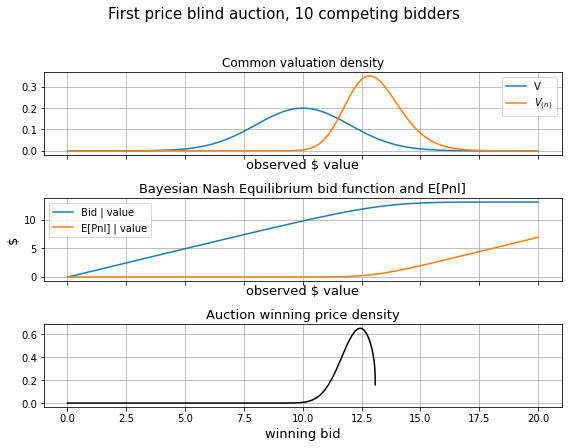

In [4]:
from scipy.integrate import quad
np.seterr(all='raise')
loc = 10
scale = 2
V = stats.norm(loc=loc, scale=scale)
n = 10 # Number of competing participants

def bid(value, n=1):
    if n == 1:
        bid = loc - scale**2*V.pdf(value) / V.cdf(value)
    else:
        Vloc, Vscale = V.stats(moments='mv'); Vscale = Vscale**0.5
        integral = quad(lambda v : V.cdf(v)**n, Vloc-Vscale*5, value)
        bid = value - 1/V.cdf(value)**n * integral[0]
    epnl = (value - bid)*V.cdf(value)**n
    return bid, epnl
    
# ====================
# ===== Plotting =====
# ====================
fig, axs = plt.subplots(3, 1, figsize=(8,6), sharex=True)
fig.suptitle('First price blind auction, {} competing bidders'.format(n), y=1.03, fontsize=15)
vals = np.linspace(1e-5, loc*2, 100)
bids, epnl = zip(*[bid(v, n) for v in vals])
bids = np.array(bids)
epnl = np.array(epnl)

axs[0].set_title('Common valuation density')
axs[0].set_xlabel('observed $ value', fontsize=13)
axs[0].plot(vals, V.pdf(vals), label='V')
axs[0].plot(vals, n*V.cdf(vals)**(n-1)*V.pdf(vals), label='$V_{(n)}$')
axs[0].legend()

axs[1].set_title('Bayesian Nash Equilibrium bid function and E[Pnl]', fontsize=13)
axs[1].set_xlabel('observed $ value', fontsize=13)
axs[1].set_ylabel('$', fontsize=13)
axs[1].plot(vals, bids, label='Bid | value')
#axs[1].plot(vals, vals, color='k', label='')
axs[1].plot(vals, epnl, label='E[Pnl] | value')
axs[1].legend()

axs[2].set_title('Auction winning price density', fontsize=13)
m = n+1 # m=n+1 for distribution of winning bid. m=n for competitors highest bid.
axs[2].plot(bids, m*V.cdf(vals)**m / (n*(vals-bids)), color='k')
axs[2].set_xlabel('winning bid', fontsize=13)

#axs[3].set_title('Our Pnl distribution', fontsize=13)
#axs[3].set_xlabel('observed $ value', fontsize=13)
#axs[3].set_ylabel('$', fontsize=13)
# axs[3].plot(bids, V.cdf(vals) / (n*(vals-bids))) density of bids for each player. f_v mapped to g(v)

EPNL = quad(lambda value: bid(value,n)[1]*V.pdf(value), 0, loc*2)[0]
print('Mean participant Pnl = {:.2f}'.format(EPNL))
EB = quad(lambda value: (n+1)*bid(value)[0]* V.pdf(value) * V.cdf(value)**n, 0, loc*2)[0]
print('Mean auction execution price = {:.2f}'.format(EB))

for ax in axs.flatten():
    ax.grid()
fig.tight_layout()

# === Simulation ====
if 0:
    nsim = 10000
    obs = V.rvs((nsim, n+1))
    pnl = np.zeros(nsim)
    winprice = np.empty(nsim)
    for i in range(nsim):
        v1 = obs[i,0]
        v2 = obs[i,1]
        b1,_ = bid(v1, n)
        b2,_ = bid(v2, n)
        pnl[i] = (b2>b1)*(v2-b2)
        winprice[i] = max(b1,b2)
    plt.figure()
    axs[1].hist(winprice, bins=100, density=True)
    plt.figure()
    plt.hist(pnl[pnl>0], bins=100, density=True)
    print(pnl.mean())
    print(pnl[pnl>0].mean())
    plt.show()

# 2. Market Making

## 2.1. Myopic one step optimzation, exp utility
That is, we are a monopolistic dealer in a single security, and publish bid/ask spreads in the market. At each time step, orders arrives with some probably that decays with the size of the bid/ask. The task is to find what bid/ask spreads to publish, and what proportion of inventory to hedge in the market (which we have to pay for).

Hence, the terminal cumulative Pnl is a stochastic metric which is a function of the time dependent parameters (bid, ask, hedge ratio).

    Algo 1: Finds spreads and amount to hedge by maximizing the expected Pnl.
    Algo 2: Finds spreads and amount to hedge by maximizing the Pnl Sharpe ratio.
    Algo 3: Finds spreads and amount to hedge by maximizing the expected exponential utility function of the Pnl.

All algos are greedy in the sense that they only consider step-wise maximization over every time step, and not over the full time space.

Result:
* Algo 1 has the highest expected terminal profit, since it disregards inventory risk, but also highest volatility among the algos. Since the order arrival distribution is time stationary, bids and asks are time invariant. That is, neither internalization nor hedging are performed due to the ignorance of risk.
* Algo 2 penalizes inventory risk, but not enough to make a large impact on volatility. This is likely due to the greedy step wise approach. Some internalization through narrowing of bid ask, but almost no skewing.
* Algo 3 penalizes inventory risk according to our risk aversion (reduces to Algo 1 as a special case when risk-neutral). Spreads turns out to be published at a risk neutral baseline (+-1 USD), with skewing on top to avoid inventory to drift too far away from flat. When internalization fails and inventory drifts too far, costly hedging is performed. The more risk-averse we are, the more aggressive we are on our spreads, and the more we are going to hedge in the market. The time of hedging can be equivalently expressed as inventory hitting a risk-limit.


[]

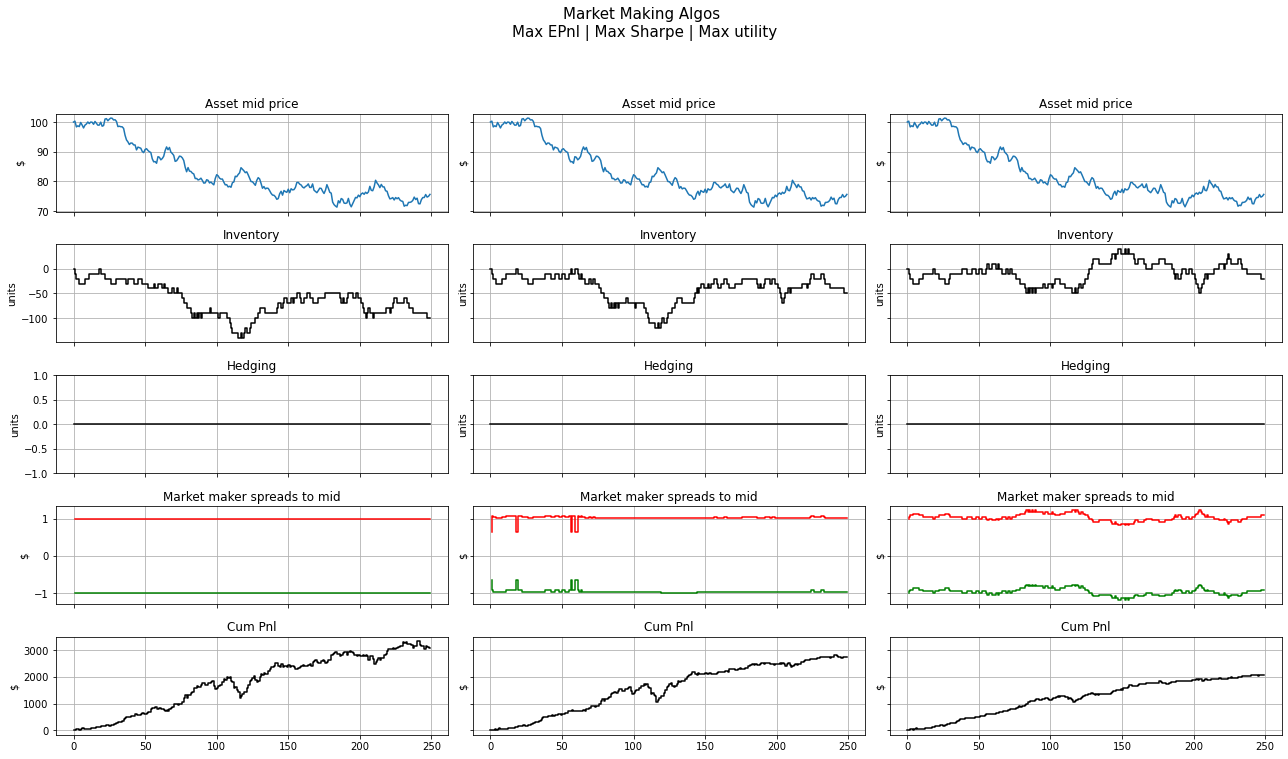

In [5]:
alpha = 1.0
T = 250
TT = np.arange(T)
s0 = 100
blackvol = 0.15 / (250)**0.5
vol = s0*(np.exp(blackvol**2)-1)**0.5
hdgCost = 0.5
# ========
from scipy.optimize import minimize

def Amu(a):
    return np.exp(-alpha*a)
def Bmu(b):
    return Amu(b)

def E(bidsprd, asksprd, hdgprop, state):
    I = state['inventory']
    s = state['mtmprice']
    return asksprd*Amu(asksprd) + bidsprd*Bmu(bidsprd) - hdgprop*np.abs(I)*hdgCost

def V(bidsprd, asksprd, hdgprop, state):
    muA = Amu(asksprd)
    muB = Bmu(bidsprd)
    I = state['inventory']
    volterm1 = (1-hdgprop)*I*((1-hdgprop)*I - hdgprop + 2*(muB-muA))
    volterm2 = muB - 2*muA*muB + muA
    term3 = asksprd**2 * muA*(1-muA) + bidsprd**2 * muB*(1-muB)
    return (volterm1 + volterm2)*vol**2 + term3

def sharpe_cost(x, state):
    bidsprd = x[0]
    asksprd = x[1]
    hdgprop = x[2] if state['allowHdg'] else 0.0
    return -E(bidsprd, asksprd, hdgprop, state)/V(bidsprd, asksprd, hdgprop, state)**0.5

def exputil_cost_legacy(x, state):
    b, a = (x[0], x[1])
    hdgprop = x[2] if state['allowHdg'] else 0.0
    #print('hdgprop: {}'.format(hdgprop))
    s = state['mtmprice']
    I = state['inventory']
    Ipost = I #*(1.0-hdgprop)
    q = state['exputil_q']
    muA = np.exp(-alpha*a)
    muB = np.exp(-alpha*b)
    psi = (q*vol)**2
    e1 = np.exp(psi*Ipost**2)*(1-muA)*(1-muB)
    e2 = np.exp(-q*b + psi*(Ipost+1)**2)*(1-muA)*muB
    e3 = np.exp(-q*a + psi*(Ipost-1)**2)*muA*(1-muB)
    e4 = np.exp(-q*(a+b) + psi*Ipost**2)*muA*muB
    #print((psi*Ipost**2, -q*b + psi*(Ipost+1)**2, -q*a + psi*(Ipost-1)**2, -q*(a+b) + psi*Ipost**2))
    hdgfactor = 1.0 #np.exp(-q*hdgprop*I*(1-hdgCost-s))
    #print('hdgfactor: {}'.format(hdgprop))
    tmp = -1/q*(1-(e1 + e2 + e3 + e4)) * hdgfactor
    if np.isinf(tmp):
        print('===== INF DETECTED =====')
        print(Ipost**2)
        print(psi*Ipost**2)
        print(-q*b + psi*(Ipost+1)**2)
        print(-q*a + psi*(Ipost-1)**2)
        print(-q*(a+b) + psi*Ipost**2)
    return -1/q*(1-(e1 + e2 + e3 + e4)) * hdgfactor

def exputil_cost(x, state):
    b, a = (x[0], x[1])
    hdgprop = x[2] if state['allowHdg'] else 0.0
    #print('hdgprop: {}'.format(hdgprop))
    s = state['mtmprice']
    I = state['inventory']
    Ipost = I #*(1.0-hdgprop)
    q = state['exputil_q']
    muA = np.exp(-alpha*a)
    muB = np.exp(-alpha*b)
    Q1 = lambda Ai,Bi: Bi-Ai + (1-hdgprop)*I
    Q2 = lambda Ai,Bi: a*Ai + b*Bi - hdgprop*np.abs(I)*hdgCost
    PrAB = lambda Ai,Bi: muA**Ai * (1-muA)**(1-Ai) * muB**Bi * (1-muB)**(1-Bi)
    caseAB = lambda Ai, Bi: np.exp(0.5*(q*vol)**2 * Q1(Ai,Bi)**2 - q*Q2(Ai,Bi))
    case00 = caseAB(0,0)*PrAB(0,0)
    case01 = caseAB(0,1)*PrAB(0,1)
    case10 = caseAB(1,0)*PrAB(1,0)
    case11 = caseAB(1,1)*PrAB(1,1)
    return -1/q * (1.0 - (case00 + case01 + case10 + case11))

def algo_max_epnl(state):
    a = max(0, 1/alpha)
    b = max(0, 1/alpha)
    return np.array([b, a, 0.0])
    
def algo_max_sharpe(state):
    bnds = [(1e-10, None), (1e-10, None), (1e-10, 0.99999)]
    x0 = (state['prev_bidsprd'], state['prev_asksprd'], 0.0)
    res = minimize(sharpe_cost, x0, args=(state), bounds=bnds)
    return res.x

def algo_max_exputil(state, riskaversion):
    bnds = [(1e-10, 5.0), (1e-10, 5.0), (1e-10, 0.99999)]
    x0 = (state['prev_bidsprd'], state['prev_asksprd'], 1e-9)
    state['exputil_q'] = riskaversion
    res = minimize(exputil_cost, x0, args=(state), bounds=bnds)
    return res.x

# ========
class Trade:
    def __init__(self, itime, size, direction, midprice, sprd):
        self.itime = itime
        self.sprd = sprd
        self.direction = direction
        self.midprice = midprice
        self.size = size
        
class Market:
    def __init__(self, s0, vol, rnd_state=None):
        self.itime = 0
        self.s = [s0]
        self.vol = vol
        self.rnd_state = rnd_state
    def evolve(self):
        s = self.s[-1] + self.vol*stats.norm().rvs(self.rnd_state)
        self.s += [s]
        self.itime +=1
        return
    def match(self, bidsprd, asksprd):
        if hasattr(self, '_urnd') and self._urnd[0] == self.itime:
            urnd = self._urnd[1]
        else:
            urnd = stats.uniform().rvs(2)
            setattr(self, '_urnd', (self.itime, urnd))
        
        pHitAsk = np.exp(-alpha*asksprd)
        pHitBid = np.exp(-alpha*bidsprd)
        trds = []
        if urnd[0] < np.exp(-alpha*asksprd):
            trds.append(Trade(itime=self.itime, size=10, direction=-1, midprice=self.s[self.itime], sprd=asksprd))
        if urnd[1] < np.exp(-alpha*bidsprd):
            trds.append(Trade(itime=self.itime, size=10, direction=+1, midprice=self.s[self.itime], sprd=bidsprd))
        return trds
    
#    def hedge(self, size, direction):
#        trds = []
#        trds.append(Trade(itime=self.itime, size=size, direction=direction, midprice=self.s[self.itime], sprd=hdgCost))
#        return trds
    
class Agent:
    def __init__(self, name, algo_func):
        self.name = name
        self.inv = [0]
        self.cash = [0]
        self.mtm = [0]
        self.cpnl = [0]
        self.bidsprd = [0]
        self.asksprd = [0]
        self.hdgprop = [0]
        self.algo_func = algo_func
    def pnl(self):
        return np.insert(np.diff(self.cpnl), 0, 0)
    def update(self, trades, mtmprice):
        deltaUnits = sum(trd.direction*trd.size for trd in trades)
        deltaCash = sum((trd.sprd - trd.direction*trd.midprice)*trd.size for trd in trades)
        self.inv.append(self.inv[-1] + deltaUnits)
        self.cash.append(self.cash[-1] + deltaCash)
        self.mtm.append(self.inv[-1] * mtmprice)
        self.cpnl.append(self.cash[-1] + self.mtm[-1])
        state = {
            'inventory':self.inv[-1],
            'mtmprice':mtmprice,
            'prev_bidsprd': self.bidsprd[-1],
            'prev_asksprd': self.asksprd[-1],
            'allowHdg': True
            }
        bidsprd, asksprd, hdgprop = self.algo_func(state)
        #print('publish: {}, {}'.format(bidsprd, asksprd))
        if np.isnan(bidsprd) or np.isnan(asksprd):
            print(state)
        
        # Hedge
        self.cash[-1] += hdgprop*(self.inv[-1]*mtmprice - np.abs(self.inv[-1])*hdgCost)
        self.inv[-1] *= (1-hdgprop)
        self.mtm[-1] = self.inv[-1]*mtmprice
        self.cpnl[-1] = (self.cash[-1] + self.mtm[-1])
        
        self.bidsprd.append(bidsprd)
        self.asksprd.append(asksprd)
        self.hdgprop.append(hdgprop)
        return (bidsprd, asksprd)
# ========


nsim = 100
pnlsim = np.zeros((nsim, 3))
pnlvolsim = np.zeros((nsim, 3))
for i in range(nsim):
    exchange = Market(s0=s0, vol=vol)
    agent1 = Agent(name='Max EPnl', algo_func=algo_max_epnl)
    agent2 = Agent(name='Max Sharpe', algo_func=algo_max_sharpe)
    agent3 = Agent(name='Max utility', algo_func=lambda state : algo_max_exputil(state, riskaversion=0.005))

    agents = [agent1, agent2, agent3]
    trds = [[]]*len(agents)
    for i in range(1, T):
        exchange.evolve()
        for i in range(len(agents)):
            bidask = agents[i].update(trds[i], mtmprice=exchange.s[-1])
            trds[i] = exchange.match(bidask[0], bidask[1])
    
    for ak, a in enumerate(agents):
        pnl = a.pnl()
        pnlsim[i, ak] = np.mean(pnl)
        pnlvolsim[i, ak] = np.std(pnl)

epnl = np.mean(pnlsim, axis=0)
epnlvol = np.mean(pnlvolsim, axis=0)
#print(epnl)
#print(epnlvol)

fig, axs = plt.subplots(5, 3, figsize=(18,10), sharex='col', sharey='row')
maintitle = 'Market Making Algos \n' + ' | '.join([a.name for a in agents])
fig.suptitle(maintitle, fontsize=15, y=1.05)
for i,agnt in enumerate(agents):
    axs[0,i].set_title('Asset mid price')
    axs[0,i].set_ylabel('$')
    axs[0,i].plot(exchange.s)
    
    axs[1,i].set_title('Inventory')
    axs[1,i].set_ylabel('units')
    axs[1,i].step(TT, agnt.inv, color='k')

    axs[2,i].set_title('Hedging')
    axs[2,i].set_ylabel('units')
    axs[2,i].step(TT, np.array(agnt.hdgprop)*np.array(agnt.inv), color='k')
    lb, ub = axs[2,i].get_ylim()
    axs[2,i].set_ylim(min(lb, -1), max(ub, 1))
    #axs[2,i].set_ylim(axs[1,i].get_ylim())
    
    axs[3,i].set_title('Market maker spreads to mid')
    axs[3,i].set_ylabel('$')
    axs[3,i].step(TT[1::], agnt.asksprd[1::], color='r')
    axs[3,i].step(TT[1::], -np.array(agnt.bidsprd[1::]), color='g')

    axs[4,i].set_title('Cum Pnl')
    axs[4,i].set_ylabel('$')
    axs[4,i].step(TT, agnt.cpnl, color='k')
    #axs21 = axs[4,i].twinx()
    #axs21.set_ylabel('Cash, Mtm')
    #axs21.step(TT, agnt.mtm, color='b', linewidth=0.5)
    #axs21.step(TT, agnt.cash, color='y', linewidth=0.5)

for ax in axs.flatten():
    ax.grid()
fig.tight_layout()
plt.plot()